In [1]:
%load_ext blackcellmagic

In [2]:
import os, pdb
import pandas as pd
import seaborn as sns
from typing import Tuple, Dict, List, Optional, Union, Set
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegressionCV
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.regressor import ResidualsPlot
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, balanced_accuracy_score
import time, datetime
import numpy as np
import joblib
import warnings
%matplotlib inline

/home/rohail/.conda/envs/imdb/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Parameters

In [3]:
TARGET_CUTOFF = 7.5
PROJECT_BASE_DIR = "/home/rohail/projects/imdb_ratings/"
model_save_dir = "models/"
data_dir = "data/raw/"
plot_write_dir = "reports/figures"
idx_columns = ["imdb_title_id", "title", "original_title"]

In [4]:
main_fname = "movies.csv"
df = pd.read_csv(os.path.join(PROJECT_BASE_DIR, data_dir, main_fname))
df.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0
3,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2019,NaN,NaN,NaN,NaN,28.0,14.0
4,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,1913,"Biography, Drama",60,USA,English,Sidney Olcott,...,"R. Henderson Bland, Percy Dyer, Gene Gauntier,...","An account of the life of Jesus Christ, based ...",5.7,438,NaN,NaN,NaN,NaN,12.0,5.0


# Exploratory analysis of target -- distribution, etc

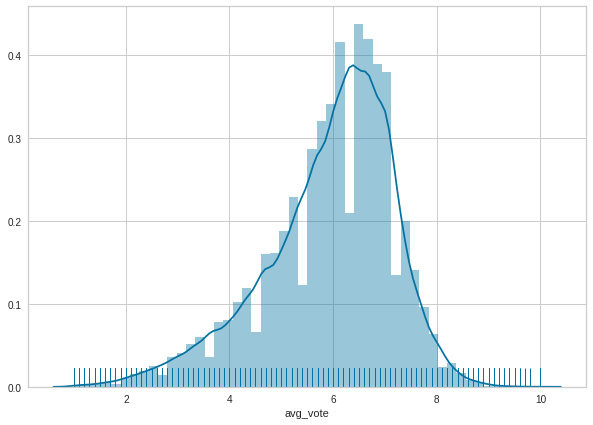

In [5]:
fig, ax = plt.subplots(figsize=(10,7))            
sns.distplot(df["avg_vote"], rug=True)

In [6]:
df["avg_vote"].describe()

count    81273.000000
mean         5.926587
std          1.243315
min          1.000000
25%          5.200000
50%          6.100000
75%          6.800000
max         10.000000
Name: avg_vote, dtype: float64

## Binarize the target

In [7]:
df.loc[:, "avg_vote_flag"] = (df.avg_vote >= TARGET_CUTOFF).astype(int)
class_balance = df.avg_vote_flag.value_counts()
percentage_of_total = float(
    (class_balance[class_balance.index == 1]) / class_balance.sum()
)
percent = "{:.2%}".format(percentage_of_total)

if class_balance.loc[1] < 5:
    print("Not fitting model due to lack of positive samples.")

print(
    f"The positive class represents {percent} of the total instances.\n"
    f"Positives: {class_balance.loc[1]}, negatives: {class_balance.loc[0]}"
)

The positive class represents 7.01% of the total instances.
Positives: 5696, negatives: 75577


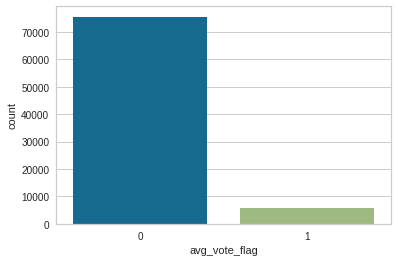

In [8]:
sns.countplot(df["avg_vote_flag"])

In [9]:
df.isnull().sum().sort_values()

imdb_title_id                0
votes                        0
avg_vote                     0
duration                     0
genre                        0
avg_vote_flag                0
year                         0
title                        0
date_published               0
original_title               0
country                     39
actors                      66
director                    73
language                   755
writer                    1493
description               2430
production_company        4325
reviews_from_users        7077
reviews_from_critics     10987
worlwide_gross_income    51381
budget                   58469
usa_gross_income         66179
metascore                68551
dtype: int64

# Enrich data with features - Dummy: see feature-engineering notebook

In [10]:
def enrich_with_features(
    df: pd.DataFrame, idx_columns: List[str], dummy: bool
) -> pd.DataFrame:
    if dummy:
        cols2keep = ["year", "duration"]
        select = idx_columns + cols2keep + ["avg_vote_flag", "avg_vote"]

    return df.loc[:, select].copy()


df_subset = enrich_with_features(df, idx_columns, dummy=True)
df_subset.head()

,imdb_title_id,title,original_title,year,duration,avg_vote_flag,avg_vote
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,0,6.1
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,53,0,5.9
2,tt0002101,Cleopatra,Cleopatra,1912,100,0,5.2
3,tt0002130,L'Inferno,L'Inferno,1911,68,0,7.0
4,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,60,0,5.7


# Scaling data/dummy encoding, etc

In [11]:
def prepare_data_for_sklearn(df: pd.DataFrame, idx_columns):
    return df.copy()

df_model = prepare_data_for_sklearn(df_subset, idx_columns)

df_model.head()

,imdb_title_id,title,original_title,year,duration,avg_vote_flag,avg_vote
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,0,6.1
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,53,0,5.9
2,tt0002101,Cleopatra,Cleopatra,1912,100,0,5.2
3,tt0002130,L'Inferno,L'Inferno,1911,68,0,7.0
4,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,60,0,5.7


# Train model
important to not miss the high rating movies

In [12]:
def summarise_classifier_performance(
    model: Union[LogisticRegression, LogisticRegressionCV],
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    x_test: pd.DataFrame,
    y_test: pd.DataFrame,
) -> plt.Figure:
    """
    Summarize model performance on train and test set and ROC on test set

    Args:
        model: A trained LogisticRegressionCV object
        x_train: Train subset for features
        y_train: Train subset for target variable
        x_test: Test subset for features
        y_test: Test subset for target variable

    Returns:
        A matplotlib object visualizing ROC curve on test set
    """
    if isinstance(model, LogisticRegressionCV):
        chosen_C = model.C_[0]
        print(f"Optimal C parameter: {chosen_C}")
    elif isinstance(model, LogisticRegression):
        chosen_C = model.get_params().get("C")
        print(f"C parameter: {chosen_C}")

    y_train_scores = model.decision_function(x_train)
    y_test_scores = model.decision_function(x_test)
    auc_train = roc_auc_score(y_train, y_train_scores).round(3)
    auc_test = roc_auc_score(y_test, y_test_scores).round(3)
    print(f"AUC score on train set: {auc_train}")
    print(f"AUC score on test set : {auc_test}")
    fpr, tpr, auc_thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
    roc_plt = plot_roc_curve(
        fpr, tpr, label=f"AUC score on test set: {auc_test} for chosen C: {chosen_C}"
    )

    return roc_plt


def plot_roc_curve(fpr: np.array, tpr: np.array, label=None) -> plt.Figure:
    """
    The ROC curve, modified from
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91

    Args:
        fpr: Increasing false positive rates such that element i is the false
        positive rate of predictions with score >= thresholds[i]
        tpr: Increasing true positive rates such that element i is the true
        positive rate of predictions with score >= thresholds[i].
        label: Title for the plot

    Returns:
        A matplotlib object visualizing ROC curve for provided tpr and fpr
    """
    roc_fig = plt.figure(figsize=(8, 8))
    plt.title("ROC Curve" if not label else label)
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0, 1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    return roc_fig


def get_model_coefficients(
    model: Union[LogisticRegressionCV, LinearRegression], features: pd.DataFrame
) -> pd.DataFrame:
    """
    Retrieve model coefficients

    Args:
        model: A trained LogisticRegression
        features: The pd.DataFrame containing features

    Returns:
        A pd.DataFrame containing the coefficients
    """
    intercept = model.intercept_
    intercept = (
        np.array(intercept).reshape((1,)) if isinstance(intercept, float) else intercept
    )
    df_coefs = pd.DataFrame(
        {"coefficients": np.concatenate((intercept, model.coef_.flatten()))},
        index=["intercept"] + features.columns.tolist(),
    )
    if isinstance(model, LogisticRegression) or isinstance(model, LogisticRegressionCV):
        df_coefs.loc[:, "coeff_odds_exponentiated"] = np.exp(df_coefs["coefficients"])

    return df_coefs.reset_index()


def _plot_precision_recall(precisions, recalls, thresholds, ax, plot_write_dir):
    def frange(start, stop, step):
        i = start
        while i < stop:
            yield np.round(float(i), 3)
            i += step

    # Ensure thresholds ends at 1
    thresholds = np.append(thresholds, 1)
    threshold_fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    ax.plot(thresholds, precisions, color="blue", label="precisions")
    ax.plot(thresholds, recalls, color="red", label="recalls")
    idx = np.argwhere(np.diff(np.sign(precisions - recalls))).flatten()
    optimum_threshold = thresholds[idx]
    if (len(optimum_threshold) > 1) and (
        np.allclose(optimum_threshold, optimum_threshold[0], atol=1e-1)
    ):
        optimum_threshold = optimum_threshold[0]
        idx = idx[:1]
    ax.set_xticks(list(frange(0, 1, 0.1)))
    print("optimal threshold: ", optimum_threshold.round(3))
    ax.plot(optimum_threshold, precisions[idx], "ro")
    ax.legend()
    threshold_fig.savefig(
        os.path.join(plot_write_dir, "classification_threshold_fig.png")
    )
    return optimum_threshold


def optimize_decision_threshold(
    model: Union[LogisticRegression, LogisticRegressionCV],
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    cv: StratifiedKFold,
    plot_write_dir: str,
):
    y_scores = cross_val_predict(model, x_train, y_train, cv=cv, method="predict_proba")

    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:, 1])
    optimum_threshold = _plot_precision_recall(
        precisions, recalls, thresholds, ax, plot_write_dir
    )
    return optimum_threshold


def fit_model(
    X: pd.DataFrame,
    y: pd.Series,
    parameters: Dict,
    load_from_disk: Optional[str] = None,
) -> Tuple[Union[LogisticRegression, LogisticRegressionCV], pd.DataFrame]:
    """
    Helper to train the model or load from disk
    """
    model_type = parameters["model_type"]
    test_set_size = parameters["test_set_size"]
    model_save_dir = parameters["model_save_dir"]
    idx_columns = parameters["idx_columns"]

    plot_write_dir = parameters.get("plot_write_dir")

    if model_type == "regression":
        x_train, x_test, y_train, y_test = train_test_split(
            X, y, test_size=test_set_size, stratify=X["avg_vote_flag"], random_state=123
        )
        cv = ShuffleSplit(n_splits=5, random_state=0)
        cv.get_n_splits(x_train, y_train)
    else:
        x_train, x_test, y_train, y_test = train_test_split(
            X, y, test_size=test_set_size, stratify=y, random_state=123
        )
        cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
        cv.get_n_splits(x_train, y_train)

    # Create lookup between index and train to retrieve idx columns for y_test ....
    idx2lookup_cols = x_test.loc[:, idx_columns].copy()
    # drop the extra target column... leaking information...
    target_column = [col for col in x_train.columns if "avg_vote" in col]
    x_train = x_train.drop(columns=idx_columns + target_column)
    x_test = x_test.drop(columns=idx_columns + target_column)

    if load_from_disk:
        path2model = os.path.join(model_save_dir, load_from_disk)
        assert os.path.exists(path2model)
        print(f"Loading model from {path2model}")
        model = joblib.load(path2model)
        df_coefficients = get_model_coefficients(model, x_train)
        y_test = idx2lookup_cols.join(y_test)
        assert all(y_test.isna().sum() == 0)
        return model, df_coefficients, x_test, y_test

    start = time.time()
    if model_type == "classification":
        fit_params = parameters["training_parameters"]
        # train a logistic regression model
        #         model = LogisticRegression(verbose=0, penalty="l2", random_state=123)
        model = LogisticRegressionCV(**fit_params, verbose=0, cv=cv, random_state=123)

        # NB: max_iter should be increased, because the current value 300 is often reached:
        # it suggests that fitting stops before convergence.
        model.fit(x_train, y_train)

        # optimize the decision threshold
        optimum_threshold = optimize_decision_threshold(
            model, x_train, y_train, cv, plot_write_dir
        )

        # summarize classifier performance
        roc_fig = summarise_classifier_performance(
            model, x_train, y_train, x_test, y_test
        )
        roc_fig.savefig(os.path.join(plot_write_dir, "roc_fig.png"))
    else:
        regression_diags_fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        model = LinearRegression()
        visualizer = ResidualsPlot(model)
        visualizer.fit(x_train, y_train)
        visualizer.finalize()
        regression_diags_fig.savefig(
            os.path.join(plot_write_dir, f"{model_type}_residual_diagnostics_fig.png")
        )
        visualizer.score(x_test, y_test)  # Evaluate the model on the test data

    end = time.time()
    print(f"The training took {np.round((end - start), 3)} seconds", "\n")
    value = datetime.datetime.fromtimestamp(end)
    model_path = (
        f"{model_save_dir}/{model_type}_{value.strftime('%Y_%m_%d_%H_%M')}.joblib"
    )
    joblib.dump(model, model_path)

    # retrieve coefficients
    df_coefficients = get_model_coefficients(model, x_train)
    y_test = idx2lookup_cols.join(y_test)
    assert all(y_test.isna().sum() == 0)

    return (model, df_coefficients, x_test, y_test)


def train_model(
    df_model: pd.DataFrame, parameters: Dict, load_from_disk: Optional[str] = None
) -> Tuple[LogisticRegression, pd.DataFrame]:
    """
    This function fits either a LogisticRegression or LinearRegression model from sklearn and returns the trained model
    and fitted coefficients to be visualized in a feature importance plot

    Args:
        df_model: A dataframe, which has already passed through scaling/one hot encoding, etc to be used for training
        the model. The target variable is collected from the parameters dictionary
        parameters: Contains training parameters as well as others needed for model fitting

    Returns:
        A List containing:
            1. Fitted LogisticRegressionCV object
            2. pd.DataFrame containing the fitted coefficients

    """
    # collect parameters
    model_type = parameters["model_type"]
    assert model_type in ["regression", "classification"]
    if load_from_disk:
        assert model_type in load_from_disk
    target = "avg_vote_flag" if model_type == "classification" else "avg_vote"

    nl = "\n"
    print(
        f"Diagnostic plots for this model can be found in the following directory: {nl + plot_write_dir}",
        f"\nThe model itself is saved in the following directory: {model_save_dir}",
        "\n",
        sep="",
    )
    X = df_model.drop(columns=target).copy()
    y = df_model[target].copy()

    # fit model
    model, df_coefficients, x_test, y_test = fit_model(
        X, y, parameters, load_from_disk=load_from_disk
    )

    return model, df_coefficients, x_test, y_test

Diagnostic plots for this model can be found in the following directory: 
reports/figures
The model itself is saved in the following directory: models/

The training took 2.477 seconds 

Diagnostic plots for this model can be found in the following directory: 
reports/figures
The model itself is saved in the following directory: models/

optimal threshold:  [0.711]
Optimal C parameter: 0.0001
AUC score on train set: 0.721
AUC score on test set : 0.72
The training took 34.321 seconds 



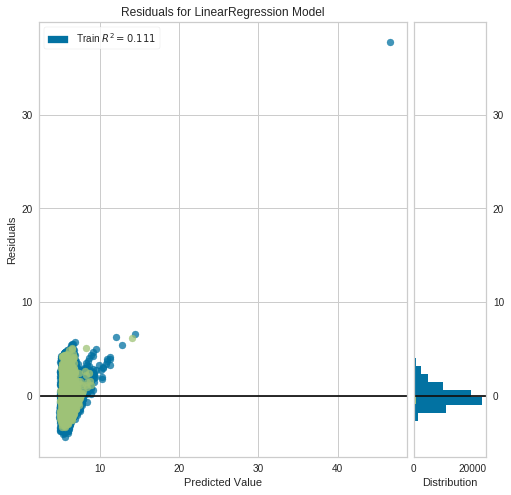

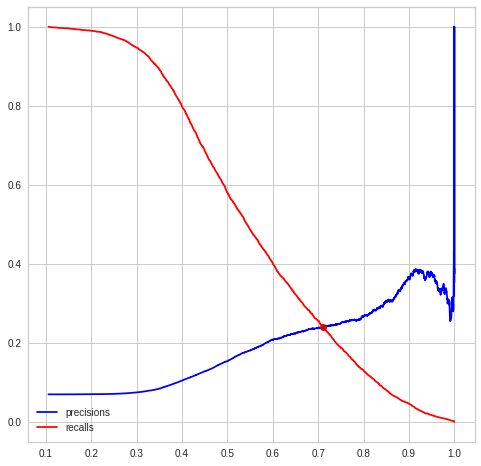

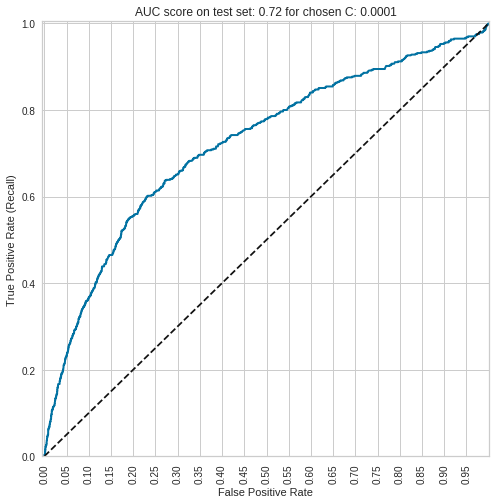

In [15]:
# regression
parameters = {
    "plot_write_dir": os.path.join(PROJECT_BASE_DIR, plot_write_dir),
    "model_save_dir": os.path.join(PROJECT_BASE_DIR, model_save_dir),
    "model_type": "regression",  # , classification
    "idx_columns": idx_columns,
    "test_set_size": 0.1,
    "training_parameters": {
        "class_weight": "balanced",  # vs providing sample weight to fit --> does it make a difference?
        "n_jobs": -1,
        #         "max_iter": 5000,
        #         "solver": "saga",
        "scoring": "balanced_accuracy",
    },
}

reg_model, df_reg_coefs, reg_x_test, reg_y_test = train_model(
    df_model, parameters=parameters,
#     load_from_disk="regression_2020_03_02_17_32.joblib"
)

# classification
parameters.update({"model_type": "classification"})
clf_model, df_clf_coefs, clf_x_test, clf_y_test = train_model(
    df_model,
    parameters=parameters,
    #     load_from_disk="classification_2020_03_02_17_35.joblib",
)
assert clf_x_test.equals(reg_x_test)
y_test = clf_y_test.join(reg_y_test.drop(columns=idx_columns))
assert len(y_test) == len(reg_x_test)
assert all(y_test.isna().sum() == 0)
assert all(y_test.index == reg_x_test.index)

# Validate model

Compare the two on same examples from test set

In [16]:
def predict_models_on_data(
    reg_model: LinearRegression,
    clf_model: LogisticRegression,
    x_test: pd.DataFrame,
    y_test: pd.DataFrame,
    features: List[str],
    parameters: Dict,
):
    classification_threshold = parameters["classification_threshold"]
    regression_threshold = parameters["regression_threshold"]
    x_test = x_test.loc[:, features].copy()
    prob_prediction = clf_model.predict_proba(x_test)[:, 1]
    classification_prediction = (prob_prediction > classification_threshold).astype(int)
    rating_prediction = reg_model.predict(x_test)
    x_test.loc[:, "clf_prob_prediction"] = prob_prediction
    x_test.loc[:, "reg_rating_prediction"] = rating_prediction
    regression_prediction = (rating_prediction >= regression_threshold).astype(int)
    x_test.loc[:, "regression_prediction"] = regression_prediction
    x_test.loc[:, "classification_prediction"] = classification_prediction
    print(x_test[["reg_rating_prediction", "clf_prob_prediction"]].describe())
    # merge together with y_text and return
    df_predict_test = x_test.join(y_test)
    assert all(df_predict_test.isna().sum() == 0)
    # check if predictions are the same
    print(
        "Regression and classification predictions the same?",
        df_predict_test["regression_prediction"].equals(
            df_predict_test["classification_prediction"]
        ),
    )
    print(
        "Balanced accuracy for regression: ",
        balanced_accuracy_score(
            df_predict_test["avg_vote_flag"], df_predict_test["regression_prediction"]
        ),
    )
    print(
        "Balanced accuracy for classification: ",
        balanced_accuracy_score(
            df_predict_test["avg_vote_flag"],
            df_predict_test["classification_prediction"],
        ),
    )
    return df_predict_test


def compare_methods(
    df_model: pd.DataFrame,
    reg_model: LinearRegression,
    clf_model: LogisticRegression,
    x_test: pd.DataFrame,
    y_test: pd.DataFrame,
    train_movies_sample: Set,
    parameters: Dict,
):
    target_columns = parameters["target_columns"]
    idx_columns = parameters["idx_columns"]
    features = list(set(df_model.columns) - set(target_columns).union(idx_columns))

    # make predictions on test data
    print("Making predictions on test data")
    df_predict_test = predict_models_on_data(
        reg_model, clf_model, clf_x_test, y_test, features, parameters
    )
    
    # make predictions on train data -- movies I know where we can identify gaps...
    x_train = df_model.loc[df_model.title.isin(train_movies_sample), features].copy()
    y_train = df_model.loc[
        df_model.title.isin(train_movies_sample), y_test.columns
    ].copy()
    print("Making predictions on sample data from train data")
    df_predict_train = predict_models_on_data(
        reg_model, clf_model, x_train, y_train, features, parameters
    )

    return df_predict_test, df_predict_train

parameters = {
    "target_columns": ["avg_vote", "avg_vote_flag"],
    "classification_threshold": 0.711, # determined from looking at diagnostic plot....
    "regression_threshold": TARGET_CUTOFF,
    "idx_columns": idx_columns,
}

train_movies_sample = {
    "The Dark Knight",
    "Anchorman: The Legend of Ron Burgundy",
    "The Big Lebowski",
    "Batman v Superman: Dawn of Justice",
    "Black Panther",
    "Kabhi Khushi Kabhie Gham...",
    "3 Idiots",
    "The Intouchables",
    "Amélie",
    "The Matrix",
    "The Matrix Reloaded",
    "V for Vendetta",
    "Kill Bill: Vol. 1",
    "La vita è bella",
    "Die Hard",
    "Requiem for a Dream",
    "Terminator 3: Rise of the Machines",
    "The Terminator",
    "Terminator 2: Judgment Day",
    "Titanic",
    "The Departed",
    "Groundhog Day",
    "Love in Kilnerry",
    "Jinnah",
    "Jawani Phir Nahi Ani",
    "Bol",
    "Das letzte Mahl",
    "The Lives of Others",
    "Das Experiment",
}

# predict on unseen examples depending on model type...
df_predict_test, df_predict_train  = compare_methods(
    df_model, reg_model, clf_model, clf_x_test, y_test, train_movies_sample, parameters
)

Making predictions on test data
       reg_rating_prediction  clf_prob_prediction
count            8128.000000          8128.000000
mean                5.929713             0.443921
std                 0.388565             0.149220
min                 4.941754             0.106291
25%                 5.643569             0.344342
50%                 5.871067             0.409600
75%                 6.161196             0.508849
max                14.095509             1.000000
Regression and classification predictions the same? False
Balanced accuracy for regression:  0.5054126451349331
Balanced accuracy for classification:  0.6011794171854616
Making predictions on sample data from train data
       reg_rating_prediction  clf_prob_prediction
count              32.000000            32.000000
mean                6.181508             0.624412
std                 0.368807             0.178541
min                 5.341506             0.269704
25%                 5.967301             0.49422